#### Лаба 2
#### Алгоритмы слежения за траекторией

Дано:
| Variant | Robot type | $\xi_0^T=[x_0\,\,\, y_0\,\,\, \vartheta_0]^T$ | $R_1$ | $\delta$ | Direction 1 | $\alpha$ | $t$ | $R_2$ | Direction 3 |
| :--------: | :-------: | :-------: | :-------: | :-------: | :-------: | :-------: | :-------: | :-------: | :-------: |
| 5 | (1,2) | $[0\,\,\, 3\,\,\,\frac{2\pi}{3}]^T$ | 7 | $2\pi$ | positive | $\frac{\pi}{3}$ | 6 |12 |clockwise |

положение робота: $\xi_b=\begin{bmatrix} x \\ y\\ \vartheta \end{bmatrix}$

поворотная матрица: $R_b^m(\vartheta)=\begin{bmatrix} cos\vartheta & sin\vartheta & 0\\ -sin\vartheta & cos\vartheta & 0 \\ 0 & 0 & 1 \end{bmatrix}$,  $\xi_b \xmapsto{R_b^m} \xi_m$

Позиционная динамическая модель c моментным управлением:
$$\dot z = B(z) u $$
$$\dot u = v$$
где $z = \begin{bmatrix} \xi \\ \beta_s \end{bmatrix}$, и $u=\begin{bmatrix} \eta \\ \zeta \end{bmatrix}$, и $v=\begin{bmatrix} v_1 \\ v_2 \end{bmatrix}$,  $B(z)=\begin{bmatrix} R^T(\vartheta)\Sigma(\beta_s) & 0 \\ 0 & I \end{bmatrix}$

Подробное описание вывода формул в [model and control LAB2.md](./specifications/model_and_control_LAB2.md)

In [97]:
import sympy as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, Math
import inspect

In [98]:
# robot model parameters
L = 0.2 # in m

In [110]:
beta_s1, beta_s2, theta, x, y, e, eta, zeta_1, zeta_2  = sm.symbols("beta_s1 beta_s2 theta x y e eta zeta_1 zeta_2")
Sigma = sm.Matrix( [[-2*L*sm.sin(beta_s1)*sm.sin(beta_s2)],[L*sm.sin(beta_s1+beta_s2)],[sm.sin(beta_s2-beta_s1)]] )
R = sm.Matrix( [[sm.cos(theta),sm.sin(theta),0],[-sm.sin(theta),sm.cos(theta),0],[0,0,1]] )
xi = sm.Matrix([[x],[y],[theta]])
u = sm.Matrix([[eta],[zeta_1],[zeta_2]])
z = sm.Matrix([[xi],[beta_s1],[beta_s2]])
B = sm.Matrix( [[R.T*Sigma, sm.zeros(3,2)],[sm.zeros(2,1), sm.diag(1,1)]] )

In [101]:
def display_expr(expr):
    frame = inspect.currentframe()
    frame = inspect.getouterframes(frame)[1]
    string = inspect.getframeinfo(frame[0]).code_context[0].strip()
    args = string[string.find('(') + 1:-1].split(',')
    
    names = []
    for i in args:
        if i.find('=') != -1:
            names.append(i.split('=')[1].strip())
        
        else:
            names.append(i)
    if names[0]=='Sigma':
        names[0] = '\\Sigma'
    if names[0]=='xi':
        names[0]='\\xi'
    str = sm.latex(expr)
    str = str.replace('\\theta','\\vartheta')

    display(Math(names[0] + '=' + str))    

In [111]:
display_expr(Sigma)
display_expr(R)
display_expr(B)
display_expr(xi)
display_expr(z)
display_expr(u)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [116]:
z = (eta,zeta_1,zeta_2,theta,beta_s1,beta_s2)
fun_B = sm.lambdify(z, B*u, modules='numpy')
fun_B(3,8,0.5,0.1,0.2,1)

array([[-0.25543635],
       [ 0.53640214],
       [ 2.15206827],
       [ 8.        ],
       [ 0.5       ]])

In [127]:
def Bu(t, z, eta, zeta_1, zeta_2):
    x,y,theta,beta_s1,beta_s2 = z
    return fun_B(eta,zeta_1,zeta_2,theta,beta_s1,beta_s2).reshape(1,5)[0]

In [128]:
Bu(_,(_,_,0.9,1,2),4,0.1,-0.1)

array([-0.84943168, -0.8887996 ,  3.36588394,  0.1       , -0.1       ])

In [152]:
T = 50 # simulating time
z0 = [0,0,-np.pi/2,2*np.pi/3,np.pi/4]
sol = sp.integrate.solve_ivp(Bu, [0, T], z0, args=(0.25, np.pi/20, np.pi/10),
                dense_output=True)

(-0.07882119812928712,
 1.2321323099313415,
 -0.04765361270299538,
 1.0007258667629029)

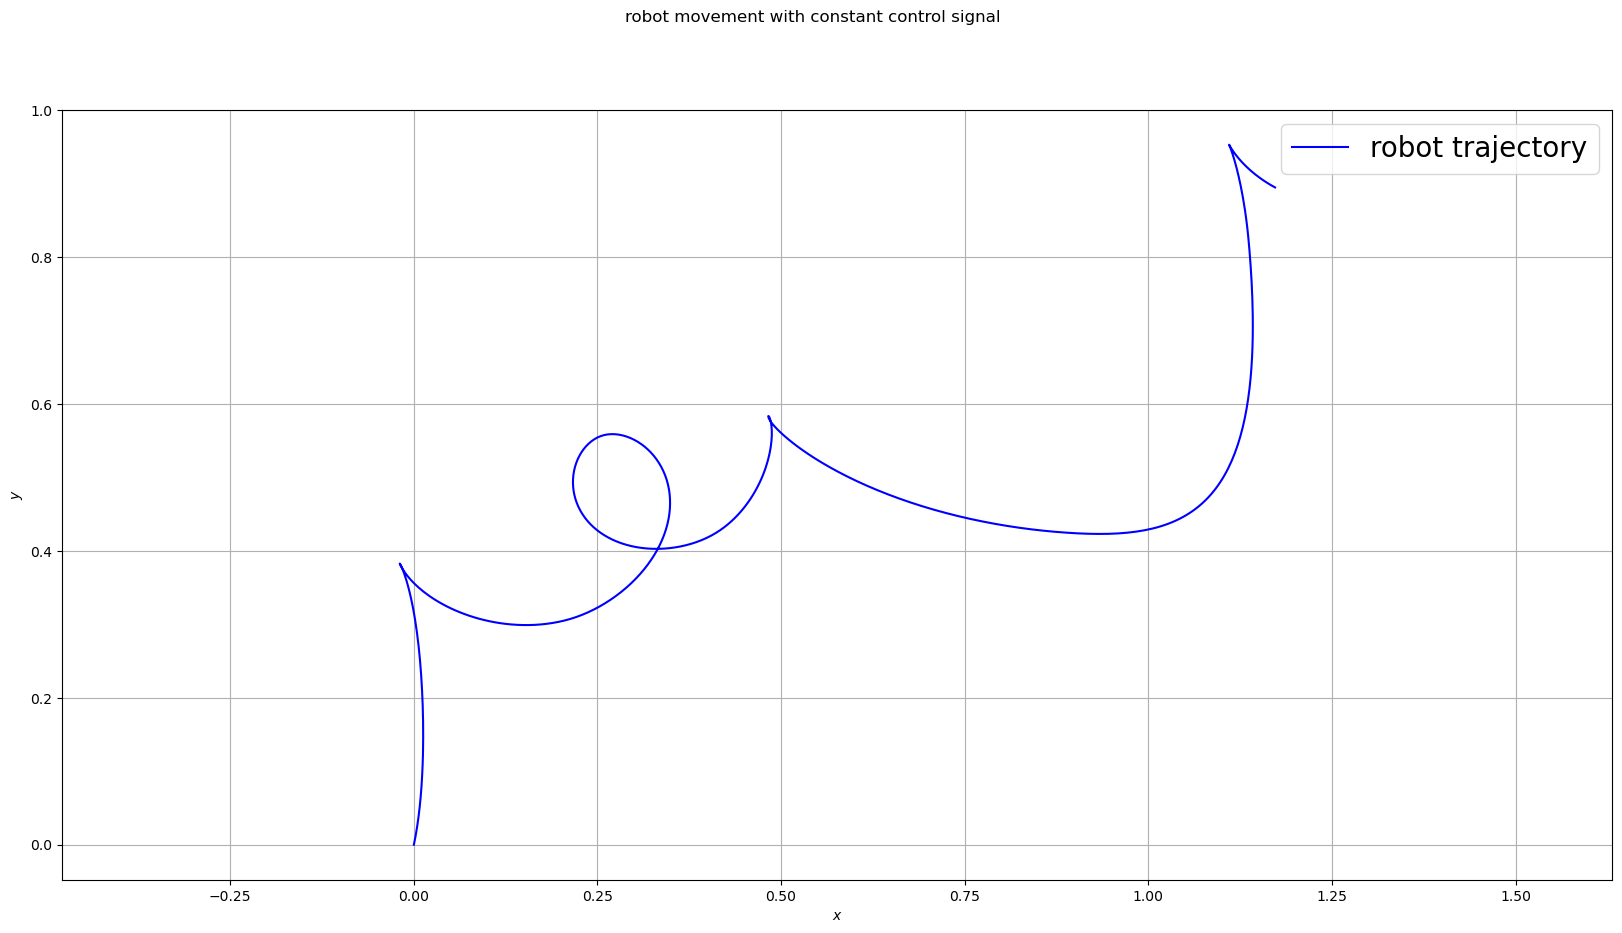

In [153]:
dt = 0.1
t = np.linspace(0, T, round(T/dt))
z = sol.sol(t)

fig, ax = plt.subplots(1,1,figsize = (20,10))
labels = ['robot MF central coordinate trajectory','$\mathcal{C}^1$','$\mathcal{C}^2$']
colours = ['b','b','orange']
ax.plot(z[0],z[1],label=labels[0],color=colours[0])

fig.suptitle("robot movement with constant control signal")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.grid(True)
ax.legend(fontsize="20",loc='upper right')
ax.axis('equal')

In [ ]:
class model:
    def __init__(self, x, y, curvature="C0", Rmin = 0.25):
        self.s = []

class simulation(model):
    def __init__(self, x, y, curvature="C0", Rmin = 0.25):
        self.